# 주제: 플레이리스트와 태그의 세부장르의 빈도의 성격을 알아보자

# 라이브러리, 데이터 로드

In [56]:
import json
import pandas as pd
import numpy as np
from datetime import datetime
from itertools import chain
from collections import Counter,defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib
from scipy.stats import skew,kurtosis
from matplotlib import font_manager, rc
import squarify
warnings.filterwarnings(action='ignore')
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

In [2]:
with open('./data/train.json','r',encoding='utf-8-sig') as f:
    playlist_df = pd.DataFrame(json.load(f))
    
with open('./data/song_meta.json','r',encoding='utf-8-sig') as f:
    song_df = pd.DataFrame(json.load(f))
    
#장르 데이터
with open('./data/genre_gn_all.json',encoding='utf-8-sig') as f:
    genre_dict = json.load(f)

# 데이터 전처리

## 노래별 세부장르 코드 취합

In [3]:
song_id_genre_detail_dict = defaultdict(list)

for id,genre_detail in zip(song_df['id'].tolist(),song_df['song_gn_dtl_gnr_basket'].tolist()):
    song_id_genre_detail_dict[id].extend(genre_detail)

## 장르 사전에 없으나 playlist 데이터에는 있는 데이터 처리

In [4]:
#genre_dict['GN9000'] = '기타장르'

## 세부장르에 대장르의 이름 넣어주기 10 -> 발라드_10

In [5]:
genre_big = {}

# 모든 장르 딕셔너리를 돌면서
for k,v in genre_dict.items():
    
    # 맨 뒤 두자리가 00이면 대장류로 분류
    if k[-2:] == '00':
        
        # 맨앞 네자리를 키로 하는 대장류 딕셔너리 값 추가
        genre_big[k[:4]] = v

genre_detail_dict = {}

# 모든 딕셔너리를 돌면서
for k,v in genre_dict.items():
    
    # 맨뒤 두자리가 00이 아니면 대장류가 아닌거임!
    if k[-2:] != '00':
        
        # 그럴떈 아까만든 대장르 딕셔너리의 대장류 이름을 추가해서 이름을 수정해서 다시 넣어줌
        new_value = genre_big[k[:4]]+'_'+v
        genre_detail_dict[k] = new_value
        
genre_big_dict = {}

for k,v in genre_big.items():
    genre_big_dict[k+'00'] = v

## 세부장르의 세부장르_전체 데이터 삭제

In [6]:
key_01 = []

for k in genre_detail_dict.keys():
    if k[-2:] == '01':
        key_01.append(k)
        
result = [genre_detail_dict.pop(key) for key in key_01]

## 취합 된 노래 별 세부장르 코드 -> 세부장르 이름으로 변경

In [7]:
for k,v in song_id_genre_detail_dict.items():
    temp = []
    for value in v:
        try:
            temp.append(genre_detail_dict[value])
        except:
            pass
    song_id_genre_detail_dict[k] = temp

## 플레이리스트 데이터 프레임에 세부장르 별 빈도 칼럼 새로 만들기

In [8]:
def genre_fetch(x):
    
    results = []
    
    for id in x:
        
        try:
            results.extend(song_id_genre_detail_dict[id])
        except:
            pass
        
    return dict(Counter(results))

playlist_df['genre_detail'] = playlist_df['songs'].map(genre_fetch)

## 태그 별 빈도수가 16을 넘는 태그에 대해서만 수행

In [9]:
tag_cnt_dict = dict(Counter(chain.from_iterable(playlist_df['tags'].tolist())))
playlist_df['tags'] = playlist_df['tags'].map(lambda x : [ tag for tag in x if tag_cnt_dict[tag]>16])

## 태그별로 함께 나온 노래 취합 및 빈도수 연산

In [10]:
tag_to_songs_dict = defaultdict(list)

for tags,songs in zip(playlist_df['tags'].tolist(),playlist_df['songs']):
    for tag in tags:
        tag_to_songs_dict[tag].extend(songs)
        
for k,v in tag_to_songs_dict.items():
    tag_to_songs_dict[k] = list(chain.from_iterable([song_id_genre_detail_dict[song] for song in v]))
    
for k,v in tag_to_songs_dict.items():
    tag_to_songs_dict[k] = dict(Counter(v))

In [11]:
playlist_df.head()

,tags,id,plylst_title,songs,like_cnt,updt_date,genre_detail
0,[락],61281,여행같은 음악,"[525514, 129701, 383374, 562083, 297861, 13954...",71,2013-12-19 18:36:19.000,"{'포크/블루스/컨트리_포크': 3, 'POP_얼터너티브팝': 5, '록/메탈_'9..."
1,"[추억, 회상]",10532,요즘 너 말야,"[432406, 675945, 497066, 120377, 389529, 24427...",1,2014-12-02 16:19:42.000,"{'발라드_'90': 1, '록/메탈_'00': 5, '발라드_'00': 3, '인..."
2,"[까페, 잔잔한]",76951,"편하게, 잔잔하게 들을 수 있는 곡.-","[83116, 276692, 166267, 186301, 354465, 256598...",17,2017-08-28 07:09:34.000,"{'R&B/Soul_R&B': 10, '인디음악_록': 4, '록/메탈_'10-':..."
3,"[연말, 눈오는날, 캐럴, 분위기, 따듯한, 겨울노래, 크리스마스, 겨울왕국]",147456,크리스마스 분위기에 흠뻑 취하고 싶을때,"[394031, 195524, 540149, 287984, 440773, 10033...",33,2019-12-05 15:15:18.000,"{'POP_'10-': 1, 'OST_애니메이션/웹툰': 3, '어린이/태교_만화'..."
4,[댄스],27616,추억의 노래 ㅋ,"[159327, 553610, 5130, 645103, 294435, 100657,...",9,2011-10-25 13:54:56.000,"{'발라드_'90': 3, '아이돌_남자 아이돌': 8, '아이돌_댄스': 13, ..."


# 플레이리스트 속 장르의 구성은 편향되어 있을까?

## 단일 플레이리스트에 대해서 파이차트 그려보기

In [12]:
def draw_pie_chart(playlist_dict):
    plt.figsize = (20,20)
    ratio = [value/sum(list(playlist_dict.values()))for value in list(playlist_dict.values())]
    labels = list(playlist_dict.keys())
    best_index = ratio.index(max(ratio))
    explode = np.zeros(len(playlist_dict))
    explode[best_index] = 0.2
    plt.pie(ratio, labels=labels, autopct='%.1f%%', startangle=260, counterclock=False, explode=explode)
    plt.show()
    plt.close()

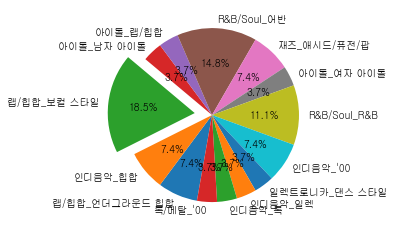

In [13]:
# 50번플레이리스트의 세부 장르 구성
draw_pie_chart(playlist_df['genre_detail'][50])

## 단일 플레이리스트 데이터와 정규분포 비교

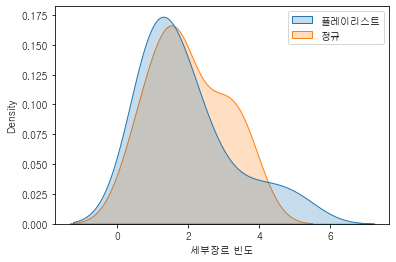

In [51]:
def draw_playlist_kedplot(playlist_id):
    playlist_cnt = list(playlist_df['genre_detail'][playlist_id].values())
    playlist_kurtosis_std = np.nanstd(playlist_cnt)
    playlist_kurtosis_mean = np.nanmean(playlist_cnt)
    playlist_len = len(playlist_df['genre_detail'][playlist_id])
    playlist_norm = np.random.normal(loc=playlist_kurtosis_mean,scale=playlist_kurtosis_std,size=playlist_len)
    
    playlist_view_data = pd.DataFrame({'플레이리스트':playlist_cnt,'정규':playlist_norm})
    
    playlist = sns.kdeplot(data=playlist_view_data,shade=True)
    playlist.set_xlabel('세부장르 빈도')

    plt.show()
    
draw_playlist_kedplot(50)

## 플레이리스트별 세부장르 구성의 첨도 칼럼생성

In [14]:
playlist_df['genre_kurtosis'] = playlist_df['genre_detail'].map(lambda x : kurtosis(list(x.values())))
playlist_df.head()

,tags,id,plylst_title,songs,like_cnt,updt_date,genre_detail,genre_kurtosis
0,[락],61281,여행같은 음악,"[525514, 129701, 383374, 562083, 297861, 13954...",71,2013-12-19 18:36:19.000,"{'포크/블루스/컨트리_포크': 3, 'POP_얼터너티브팝': 5, '록/메탈_'9...",0.279763
1,"[추억, 회상]",10532,요즘 너 말야,"[432406, 675945, 497066, 120377, 389529, 24427...",1,2014-12-02 16:19:42.000,"{'발라드_'90': 1, '록/메탈_'00': 5, '발라드_'00': 3, '인...",-0.979592
2,"[까페, 잔잔한]",76951,"편하게, 잔잔하게 들을 수 있는 곡.-","[83116, 276692, 166267, 186301, 354465, 256598...",17,2017-08-28 07:09:34.000,"{'R&B/Soul_R&B': 10, '인디음악_록': 4, '록/메탈_'10-':...",0.380838
3,"[연말, 눈오는날, 캐럴, 분위기, 따듯한, 겨울노래, 크리스마스, 겨울왕국]",147456,크리스마스 분위기에 흠뻑 취하고 싶을때,"[394031, 195524, 540149, 287984, 440773, 10033...",33,2019-12-05 15:15:18.000,"{'POP_'10-': 1, 'OST_애니메이션/웹툰': 3, '어린이/태교_만화'...",1.036531
4,[댄스],27616,추억의 노래 ㅋ,"[159327, 553610, 5130, 645103, 294435, 100657,...",9,2011-10-25 13:54:56.000,"{'발라드_'90': 3, '아이돌_남자 아이돌': 8, '아이돌_댄스': 13, ...",3.310724


## 과연 첨도가 3이 넘는 플레이리스트는 몇 퍼센트?

In [60]:
playlist_over3 = len(playlist_df[playlist_df['genre_kurtosis'] >= 3]) / len(playlist_df)
print(f'세부장르의 빈도 분포의 첨도가 3 이상인 플레이리스트는 전체에서 약 {np.round(playlist_over3*100,2)}% 입니다. ')

세부장르의 빈도 분포의 첨도가 3 이상인 플레이리스트는 전체에서 약 20.54% 입니다. 


In [61]:
playlist_less3 = len(playlist_df[playlist_df['genre_kurtosis'] < 3]) / len(playlist_df)
print(f'세부장르의 빈도 분포의 첨도가 3 미만인 플레이리스트는 전체에서 약 {np.round(playlist_less3*100,2)}% 입니다. ')

세부장르의 빈도 분포의 첨도가 3 미만인 플레이리스트는 전체에서 약 79.1% 입니다. 


## 전체 데이터 시각화

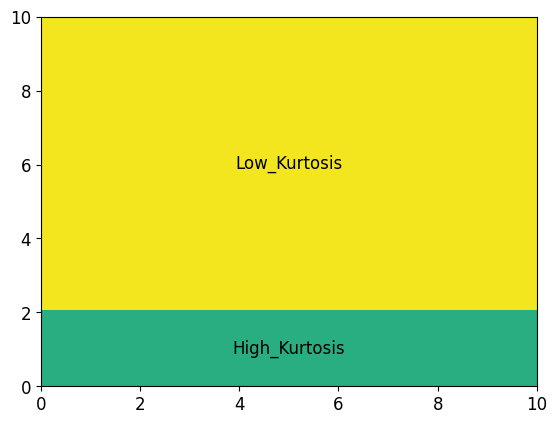

In [62]:
plt.style.use('default')
plt.rcParams['font.size'] = 12

sizes = [playlist_over3,playlist_less3]
labels= ['High_Kurtosis', 'Low_Kurtosis']

squarify.plot(sizes, 10, 10, label=labels)
plt.show()

## 결론

- 플레이리스트 별 세부장르의 수 자체가 적기 때문에 분포를 자세히 확인하기 어렵지만, 플레이리스트 별 세부장르의 점유율은 꽤 고른분포를 보인다

# 태그별 세부장르의 구성은 편향되어 있을까?

## 단일 태그 데이터에 대해서 파이차트 그려보기

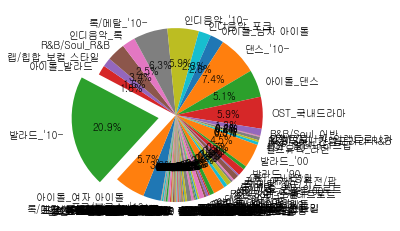

In [44]:
draw_pie_chart(tag_to_songs_dict['아이유'])

## 단일 태그 데이터와 정규분포 그래프 분포 비교

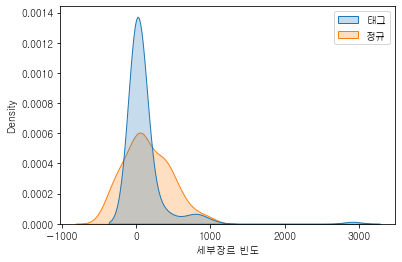

In [43]:
def draw_tag_kedplot(tag_name):
    tag_cnt = list(tag_to_songs_dict[tag_name].values())
    tag_kurtosis_std = np.nanstd(tag_cnt)
    tag_kurtosis_mean = np.nanmean(tag_cnt)
    tag_len = len(tag_to_songs_dict[tag_name])
    tag_norm = np.random.normal(loc=tag_kurtosis_mean,scale=tag_kurtosis_std,size=tag_len)
    
    tag_view_data = pd.DataFrame({'태그':tag_cnt,'정규':tag_norm})
    
    tag = sns.kdeplot(data=tag_view_data,shade=True)
    tag.set_xlabel('세부장르 빈도')

    plt.show()
    
draw_tag_kedplot('아이유')

## 태그별 세부장르 분포 첨도 구하고 단일 데이터 확인

In [20]:
tag_kurtosis = {}

for k,v in tag_to_songs_dict.items():
    tag_kurtosis[k] = kurtosis(list(tag_to_songs_dict[k].values()))

In [21]:
tag_kurtosis['락']

52.06521626263427

## 과연 첨도가 3이 넘는 태그는 몇 퍼센트?

In [22]:
kurtosis_over3 = 0
kurtosis_less3 = 0

for kurtosis in list(tag_kurtosis.values()):
    if kurtosis >=3:
        kurtosis_over3+=1
    else:
        kurtosis_less3+=1

In [23]:
over3_per = kurtosis_over3 / len(tag_kurtosis)
print(f'세부장르의 빈도 분포의 첨도가 3 이상인 태그는 전체에서 약 {np.round(over3_per*100,2)}% 입니다. ')

세부장르의 빈도 분포의 첨도가 3 이상인 태그는 전체에서 약 94.06% 입니다. 


In [24]:
less3_per = kurtosis_less3/len(tag_kurtosis)
print(f'세부장르의 빈도 분포의 첨도가 3 이상인 태그는 전체에서 약 {np.round(less3_per*100,2)}% 입니다. ')

세부장르의 빈도 분포의 첨도가 3 이상인 태그는 전체에서 약 5.94% 입니다. 


## 전체 태그 데이터 시각화

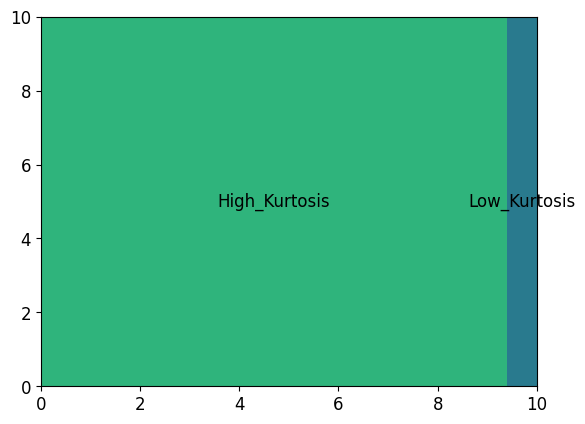

In [59]:
plt.style.use('default')
plt.rcParams['font.size'] = 12

sizes = [kurtosis_over3,kurtosis_less3]
labels= ['High_Kurtosis', 'Low_Kurtosis']

squarify.plot(sizes, 10, 10, label=labels)
plt.show()

## 결론 

 - 태그에 대한 세부장르의 분포는 전체적으로 특정 세부장르에 치우쳐 있다